# ChEMBL - Fetch Raw Data - Human

**Date:** 16/01/23

**Based on:** [TeachOpenCADD T001 - Compound data acquisition (ChEMBL)](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html)

**Done by:** Gustavo H. M. Sousa

Session information at the end of the notebook.

**Important**: this notebook was done after fetching the data for the *P. falciparum* and the notebook should be on this same directory.

### Importing, defining paths and specifying query parameters

In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client # This is the API chembl library
from tqdm.auto import tqdm

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
# We are defining the relative path so we can store the data retrieved
DATA

PosixPath('/home/gustavo/github/masters/datasets/raw/data')

Next, we move on to the API stuff:

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Target information

We now specify the UniProt ID of our target, in our case we're going to start with the following:
* **UniProt ID:** P00374
* **Entry name:** DYR_HUMAN
* **Organism:**  Homo sapiens (Human)
* **Length:** 187 AA

In [4]:
uniprot_id = "P00374"

The we fetch the data for this UniProt ID:

In [5]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(type(targets))

<class 'chembl_webresource_client.query_set.QuerySet'>


Now we retrieve our query:

In [6]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Dihydrofolate reductase,CHEMBL202,SINGLE PROTEIN
1,Homo sapiens,Dihydrofolate reductase,CHEMBL202,SINGLE PROTEIN


After inspecting ou dataframe with the *'organism'*, *'pref_name'* and *'target_chembl_id'* and *'target_type'*, we can select what row are of interest. In our case, the rows are both the same (I don't know exactly why?) so we can select either.

In [7]:
targets = targets.iloc[0]
targets

organism                       Homo sapiens
pref_name           Dihydrofolate reductase
target_chembl_id                  CHEMBL202
target_type                  SINGLE PROTEIN
Name: 0, dtype: object

Saving the 'target_chembl_id': 

In [8]:
chembl_id = targets.target_chembl_id
chembl_id

'CHEMBL202'

### Fetching biological data to our target

Now we can finally fetch the biological data for our target, taking the following into consideration:
* bioactivity type `Ki` (there are more information about in our case)
* exact measurements (relation `=`)
* binding data (assay type `B`)

In [9]:
bioactivities_human = bioactivities_api.filter(
    target_chembl_id=chembl_id, type='Ki', relation='=', assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"The total size of the biological activities fetched is: {len(bioactivities_human)} of type {type(bioactivities_human)}")

The total size of the biological activities fetched is: 394 of type <class 'chembl_webresource_client.query_set.QuerySet'>


We can now download the dataset containing only `Ki` and extract the measurements for our human target.

In [10]:
bioactivities_human_df = pd.DataFrame.from_records(bioactivities_human)
print(f"The dataframe shape is {bioactivities_human_df.shape}")

# Checking the dataframe we fetched
bioactivities_human_df

The dataframe shape is (395, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.0,CHEMBL202,Homo sapiens,Ki,uM,0.009
1,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.0,CHEMBL202,Homo sapiens,Ki,uM,0.009
2,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,nM,0.0001,CHEMBL202,Homo sapiens,Ki,pM,0.1
3,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,nM,0.00011,CHEMBL202,Homo sapiens,Ki,pM,0.11
4,150532,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149164,=,nM,0.00019,CHEMBL202,Homo sapiens,Ki,pM,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20675954,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1618254,=,nM,3400000.0,CHEMBL202,Homo sapiens,Ki,mM,3.4
391,20675955,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL3278332,=,nM,180000.0,CHEMBL202,Homo sapiens,Ki,mM,0.18
392,20675956,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1233987,=,nM,180000.0,CHEMBL202,Homo sapiens,Ki,mM,0.18
393,20675957,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL170988,=,nM,140000.0,CHEMBL202,Homo sapiens,Ki,mM,0.14


We can do a sort of estimation of unique structures in our dataset before filtering anything out.

In [11]:
print(bioactivities_human_df['molecule_chembl_id'].unique().shape[0])

273


Also, about the units types in our dataframe:

In [12]:
bioactivities_human_df['units'].unique()

array(['uM', 'pM', 'nM', "10'-3microM", 'mM'], dtype=object)

Of course we have columns for standard_units and standard_values, that is, it was automatically converted from ChEMBL. We are going to drop the raw values:

In [13]:
bioactivities_human_df.drop(['units', 'value'], axis=1, inplace=True)
bioactivities_human_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.0,CHEMBL202,Homo sapiens,Ki
1,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.0,CHEMBL202,Homo sapiens,Ki
2,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,nM,0.0001,CHEMBL202,Homo sapiens,Ki
3,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,nM,0.00011,CHEMBL202,Homo sapiens,Ki
4,150532,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149164,=,nM,0.00019,CHEMBL202,Homo sapiens,Ki


### Preprocess the data

For the pre-processing of the data we're going to do the following:

1. Convert the `standard_value` type from `object` to `float`.
2. Delete entries with missing values (I think in our case there is none)
3. Keep only nanomolar entries or convert `uM` to `nM` by applying a x1000 multiplication factor
4. Delete duplicate molecules - **That is a questionable step we could take the mean of the two**
5. Reset the `DataFrame` index
6. Rename columns

The field `standard_value` holds `Ki` values. We're going to perform some calculations later on and we need to convert them from `objects` to `float`.

This is an important step, specially when dealing with a lot of information and **you should always check each variable type** prior of doing any calculation! This is just basic data analysis good practices.

#### 1. Convert `standard_value` type

In [14]:
bioactivities_human_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [15]:
bioactivities_human_df = bioactivities_human_df.astype({'standard_value': 'float64'})
bioactivities_human_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

#### 2. Delete entries with missing values

In [16]:
bioactivities_human_df.dropna(axis=0, how='any', inplace=True)
print(f"The shape of the dataset after dropping NAs values: {bioactivities_human_df.shape[0]}")

The shape of the dataset after dropping NAs values: 395


Ok, so no NA values on this one also!

#### 3. Keep only entries with nanomolar standard units

In [17]:
print(f"The standard unity should only be nM: {bioactivities_human_df['standard_units'].unique()}")
print(f"Number of non-nM entries: {bioactivities_human_df[bioactivities_human_df['standard_units'] != 'nM'].shape[0]}")

The standard unity should only be nM: ['nM']
Number of non-nM entries: 0


Ok so we're good to go from here since there are not any non-standardized strcuture.

#### 4. Delete or group by mean duplicated molecules

Sometimes the same strcuture has been tested more than once, that is, the `molecule_chembl_id` entry appears more than once. We're going to do the mean of the measurements and also just keep the first just as it is done in the tutorial.

In [34]:
# If we want to keep also the mean of the measurements from standard values we can do:

bioactivities_human_mean_df = bioactivities_human_df[['molecule_chembl_id', 'standard_value']].groupby('molecule_chembl_id').mean().reset_index()

bioactivities_human_mean_df = bioactivities_human_mean_df.rename(columns={'standard_value': 'mean_standard_value'})

So just keep the `bioactivities_human_mean_df` dataframe for now, we're going to join the values later. We can basically just drop the duplicates by keeping only the first values, as it is taught in the tutorial but I'm going to keep both the first entries and the mean just in case, as my experience in previous QSAR works.

In [48]:
# Use it to display the format not in scientific notation
pd.set_option('display.float_format', lambda x: '%.6f' % x)

bioactivities_human_df.drop_duplicates('molecule_chembl_id', keep='first', inplace=True)
print(f"after dropping NAs we're left with {bioactivities_human_df.shape[0]} structures")

after dropping NAs we're left with 273 structures


Merging the two datasets by keeping also the mean of the `standard_values` using the function `pd.merge`.

In [49]:
merged_bioactivities_human = pd.merge(bioactivities_human_df, bioactivities_human_mean_df, how='left', on='molecule_chembl_id')
merged_bioactivities_human

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,mean_standard_value
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.000000,CHEMBL202,Homo sapiens,Ki,9.000000
1,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,nM,0.000100,CHEMBL202,Homo sapiens,Ki,0.000100
2,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,nM,0.000110,CHEMBL202,Homo sapiens,Ki,0.000110
3,150532,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149164,=,nM,0.000190,CHEMBL202,Homo sapiens,Ki,0.000190
4,152127,CHEMBL666805,Inhibitory activity against recombinant human ...,B,CHEMBL167304,=,nM,9.870000,CHEMBL202,Homo sapiens,Ki,9.870000
...,...,...,...,...,...,...,...,...,...,...,...,...
268,20675954,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1618254,=,nM,3400000.000000,CHEMBL202,Homo sapiens,Ki,3400000.000000
269,20675955,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL3278332,=,nM,180000.000000,CHEMBL202,Homo sapiens,Ki,180000.000000
270,20675956,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1233987,=,nM,180000.000000,CHEMBL202,Homo sapiens,Ki,180000.000000
271,20675957,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL170988,=,nM,140000.000000,CHEMBL202,Homo sapiens,Ki,140000.000000


Moving on into the next step that is reseting the DF index

#### 5. Reserting the DF index

Sanity check: Reseting the dataframe index, just in case any index came out of place.

In [51]:
merged_bioactivities_human.reset_index(inplace=True, drop=True)
merged_bioactivities_human

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,mean_standard_value
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.000000,CHEMBL202,Homo sapiens,Ki,9.000000
1,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,nM,0.000100,CHEMBL202,Homo sapiens,Ki,0.000100
2,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,nM,0.000110,CHEMBL202,Homo sapiens,Ki,0.000110
3,150532,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149164,=,nM,0.000190,CHEMBL202,Homo sapiens,Ki,0.000190
4,152127,CHEMBL666805,Inhibitory activity against recombinant human ...,B,CHEMBL167304,=,nM,9.870000,CHEMBL202,Homo sapiens,Ki,9.870000
...,...,...,...,...,...,...,...,...,...,...,...,...
268,20675954,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1618254,=,nM,3400000.000000,CHEMBL202,Homo sapiens,Ki,3400000.000000
269,20675955,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL3278332,=,nM,180000.000000,CHEMBL202,Homo sapiens,Ki,180000.000000
270,20675956,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1233987,=,nM,180000.000000,CHEMBL202,Homo sapiens,Ki,180000.000000
271,20675957,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL170988,=,nM,140000.000000,CHEMBL202,Homo sapiens,Ki,140000.000000


#### 6. Renaming and reordering the columns

In [52]:
merged_bioactivities_human.rename(columns={'standard_value': 'last_Ki_value','mean_standard_value':'mean_Ki_value'}, inplace=True)
merged_bioactivities_human.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,last_Ki_value,target_chembl_id,target_organism,type,mean_Ki_value
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,nM,9.000000,CHEMBL202,Homo sapiens,Ki,9.000000
1,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,nM,0.000100,CHEMBL202,Homo sapiens,Ki,0.000100
2,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,nM,0.000110,CHEMBL202,Homo sapiens,Ki,0.000110


Now we finally do the reordering:

In [53]:
merged_bioactivities_human = merged_bioactivities_human[['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id', 'relation', 'last_Ki_value', 'mean_Ki_value', 'standard_units', 'standard_units', 'target_chembl_id', 'target_organism']]

In [54]:
# The final biological activities output is:
merged_bioactivities_human

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,last_Ki_value,mean_Ki_value,standard_units,standard_units,target_chembl_id,target_organism
0,144782,CHEMBL666227,Competitive inhibition of mammalian dihydrofol...,B,CHEMBL1161155,=,9.000000,9.000000,nM,nM,CHEMBL202,Homo sapiens
1,145813,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149218,=,0.000100,0.000100,nM,nM,CHEMBL202,Homo sapiens
2,145815,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL146917,=,0.000110,0.000110,nM,nM,CHEMBL202,Homo sapiens
3,150532,CHEMBL669872,Compound was evaluated for the inhibition of D...,B,CHEMBL149164,=,0.000190,0.000190,nM,nM,CHEMBL202,Homo sapiens
4,152127,CHEMBL666805,Inhibitory activity against recombinant human ...,B,CHEMBL167304,=,9.870000,9.870000,nM,nM,CHEMBL202,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...
268,20675954,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1618254,=,3400000.000000,3400000.000000,nM,nM,CHEMBL202,Homo sapiens
269,20675955,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL3278332,=,180000.000000,180000.000000,nM,nM,CHEMBL202,Homo sapiens
270,20675956,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL1233987,=,180000.000000,180000.000000,nM,nM,CHEMBL202,Homo sapiens
271,20675957,CHEMBL4621660,Inhibition of human DHFR in presence of DHF an...,B,CHEMBL170988,=,140000.000000,140000.000000,nM,nM,CHEMBL202,Homo sapiens


### Download the compound data from ChEMBL

In [55]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(merged_bioactivities_human['molecule_chembl_id'])
).only('molecule_chembl_id', 'molecule_structures')

In [65]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/273 [00:00<?, ?it/s]

After waiting for the compounds to be gathered (using the list function I think), we can now take a peek in our SMILES strucutres gathered.

In [66]:
compounds_df = pd.DataFrame.from_records(compounds)
print(compounds_df.shape)
compounds_df.head(5)

(273, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL6948,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
1,CHEMBL22,{'canonical_smiles': 'COc1cc(Cc2cnc(N)nc2N)cc(...
2,CHEMBL268088,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
3,CHEMBL7130,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
4,CHEMBL7492,{'canonical_smiles': 'COc1ccc(OC)c(Cc2cnc3nc(N...


Performing the following steps:
1. Remove entries with missing structures
2. Delete duplicate molecule by `'molecule_chembl_id'` variable
3. Get only molecules with **Canonical SMILES**


#### 1. Remove missing structures

In [67]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(compounds_df.shape[0])

compounds_df.head(3)

273


,molecule_chembl_id,molecule_structures
0,CHEMBL6948,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
1,CHEMBL22,{'canonical_smiles': 'COc1cc(Cc2cnc(N)nc2N)cc(...
2,CHEMBL268088,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...


So no missing entries as our entry value is still 273.

#### 2. Delete duplicates

In [68]:
compounds_df.drop_duplicates('molecule_chembl_id', keep='first',
inplace=True)
print(compounds_df.shape[0])

273


#### 3. Only Canonical SMILES

Multiple outputs for the structure formats gathered in `compounds_df` but we are only interested into the `canonical_smiles`information.

In [69]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

So we can do a `for`loop to retrieve only the canonical_smiles dictionary key and that's the chunk below:

In [70]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds['molecule_structures']['canonical_smiles'])
    except KeyError:
        canonical_smiles.append(None)

compounds_df['smiles'] = canonical_smiles
compounds_df.drop('molecule_structures', axis=1, inplace=True)

Sanity check to see if there is any NA appended before:

In [71]:
compounds_df.dropna(axis=0, how='any', inplace=True)
print(f"The shape of the compounds dataset is: {compounds_df.shape}")
compounds_df.head(3)

The shape of the compounds dataset is: (273, 2)


,molecule_chembl_id,smiles
0,CHEMBL6948,CC1(C)N=C(N)N=C(N)N1c1cccc(C(F)(F)F)c1
1,CHEMBL22,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
2,CHEMBL268088,CC1(C)N=C(N)N=C(N)N1c1cccc(Br)c1


Ok, so we're finally good to go on our final output of the data.

### Output of the data

Doing a summary of the data that we have gathered so far, that is: the `merged_bioactivities_human` and the `compounds_df`. The first one contains the respective biological acitivites and the second one contains the of the respective `molecule_chembl_id`.

In [73]:
print(f"Total molecule_ids retrieved from ChEMBL for our human enzyme target: {merged_bioactivities_human.shape[0]}\n")
merged_bioactivities_human.columns

Total molecule_ids retrieved from ChEMBL for our human enzyme target: 273



Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'last_Ki_value', 'mean_Ki_value',
       'standard_units', 'standard_units', 'target_chembl_id',
       'target_organism'],
      dtype='object')

Simultaneously for the `canonical_smiles` fetched we have:

In [74]:
print(f"Total canonical smiles fetched for our human enzyme target: {compounds_df.shape[0]}\n")
compounds_df.columns

Total canonical smiles fetched for our human enzyme target: 273



Index(['molecule_chembl_id', 'smiles'], dtype='object')

So we have the same number, both 273 entries and we can merge the two datasets by the `molecule_chembl_id`! thats very good.

### Merge both datasets

Merging both datasets so we can do a `csv` for the output and get a preprocessed data and some easiness for our life in the cleaning step of the data. We're basically going to merge the datsets and keep the following columns:

* ChEMBL IDS: `molecule_chembl_id`
* SMILES: `smiles`
* Units: `standard_units`
* Last Ki: `last_Ki_value`
* Mean Ki: `mean_Ki_value`
* Target: `target_organism` - so we can tell right away what target we're talking about

In [75]:
# Merging both datsets
human_chembl_output_df = pd.merge(
    merged_bioactivities_human[['molecule_chembl_id', 'last_Ki_value','mean_Ki_value','standard_units', 'target_organism']],
    compounds_df,
    on='molecule_chembl_id'
)
human_chembl_output_df

,molecule_chembl_id,last_Ki_value,mean_Ki_value,standard_units,standard_units,target_organism,smiles
0,CHEMBL1161155,9.000000,9.000000,nM,nM,Homo sapiens,CCS(=O)(=O)O.Cc1nc(N)nc(N)c1NC(=O)C12CC3CC(CC(...
1,CHEMBL149218,0.000100,0.000100,nM,nM,Homo sapiens,Cc1c(CNc2ccc(C(=O)NC(CCCNC(=O)c3ccccc3C(=O)O)C...
2,CHEMBL146917,0.000110,0.000110,nM,nM,Homo sapiens,Nc1nc(N)c2c(Cl)c(CNc3ccc(C(=O)NC(CCCNC(=O)c4cc...
3,CHEMBL149164,0.000190,0.000190,nM,nM,Homo sapiens,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...
4,CHEMBL167304,9.870000,9.870000,nM,nM,Homo sapiens,C[C@](CCC(=O)O)(NC(=O)c1ccc(CCC2CNc3nc(N)nc(N)...
...,...,...,...,...,...,...,...
268,CHEMBL1618254,3400000.000000,3400000.000000,nM,nM,Homo sapiens,COc1ccc2cc([C@@H](C)C(=O)O)ccc2c1
269,CHEMBL3278332,180000.000000,180000.000000,nM,nM,Homo sapiens,Nc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
270,CHEMBL1233987,180000.000000,180000.000000,nM,nM,Homo sapiens,Nc1ccnc(N)n1
271,CHEMBL170988,140000.000000,140000.000000,nM,nM,Homo sapiens,N=C(N)NC(=N)NCCc1ccccc1


### Add pKi values

As it is known to the QSAR community, converting raw Ki numbers to pKi is an important step into the modeling pipeline. Because of that, we need to transform our previously collected Ki values into pKi values. First we make a function to converte pKi to Ki `convert_pki` and use the `apply()` method to do it in the vertical axis (1).

In [76]:
# define a funtion to convert Ki to pKi
def convert_pki(Ki):
    pKi_value = 9 - math.log10(Ki)
    return pKi_value

In [77]:
human_chembl_output_df['pKi_mean_value'] = human_chembl_output_df.apply(lambda x: convert_pki(x.mean_Ki_value), axis = 1)

human_chembl_output_df['pKi_last_value'] = human_chembl_output_df.apply(lambda x: convert_pki(x.last_Ki_value), axis=1)

human_chembl_output_df

,molecule_chembl_id,last_Ki_value,mean_Ki_value,standard_units,standard_units,target_organism,smiles,pKi_mean_value,pKi_last_value
0,CHEMBL1161155,9.000000,9.000000,nM,nM,Homo sapiens,CCS(=O)(=O)O.Cc1nc(N)nc(N)c1NC(=O)C12CC3CC(CC(...,8.045757,8.045757
1,CHEMBL149218,0.000100,0.000100,nM,nM,Homo sapiens,Cc1c(CNc2ccc(C(=O)NC(CCCNC(=O)c3ccccc3C(=O)O)C...,13.000000,13.000000
2,CHEMBL146917,0.000110,0.000110,nM,nM,Homo sapiens,Nc1nc(N)c2c(Cl)c(CNc3ccc(C(=O)NC(CCCNC(=O)c4cc...,12.958607,12.958607
3,CHEMBL149164,0.000190,0.000190,nM,nM,Homo sapiens,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...,12.721246,12.721246
4,CHEMBL167304,9.870000,9.870000,nM,nM,Homo sapiens,C[C@](CCC(=O)O)(NC(=O)c1ccc(CCC2CNc3nc(N)nc(N)...,8.005683,8.005683
...,...,...,...,...,...,...,...,...,...
268,CHEMBL1618254,3400000.000000,3400000.000000,nM,nM,Homo sapiens,COc1ccc2cc([C@@H](C)C(=O)O)ccc2c1,2.468521,2.468521
269,CHEMBL3278332,180000.000000,180000.000000,nM,nM,Homo sapiens,Nc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1,3.744727,3.744727
270,CHEMBL1233987,180000.000000,180000.000000,nM,nM,Homo sapiens,Nc1ccnc(N)n1,3.744727,3.744727
271,CHEMBL170988,140000.000000,140000.000000,nM,nM,Homo sapiens,N=C(N)NC(=N)NCCc1ccccc1,3.853872,3.853872


### Drawing the distributions

We can begin by comparing the distribution of the `pKi_last_value` and the `pKi_mean_value`:

array([[<AxesSubplot: title={'center': 'pKi_last_value'}>]], dtype=object)

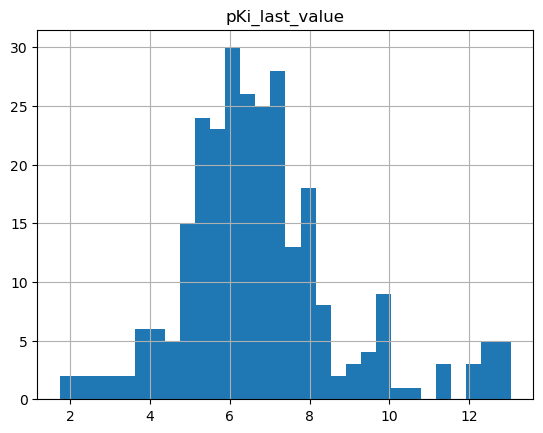

In [79]:
human_chembl_output_df.hist(column='pKi_last_value', bins=30)

array([[<AxesSubplot: title={'center': 'pKi_mean_value'}>]], dtype=object)

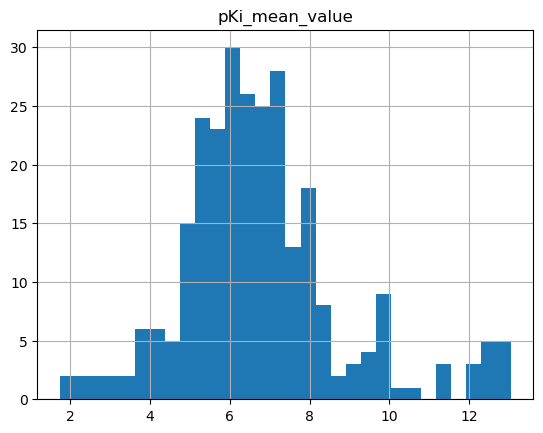

In [80]:
human_chembl_output_df.hist(column='pKi_mean_value', bins=30)

### Saving the final output (csv)

Furthermore, we need to redorder the columns to finally save it in a '.csv' file:

In [83]:
human_chembl_output_df = human_chembl_output_df[['molecule_chembl_id', 'smiles', 'pKi_mean_value', 'mean_Ki_value', 'target_organism']]

human_chembl_output_df.head(5)

,molecule_chembl_id,smiles,pKi_mean_value,mean_Ki_value,target_organism
0,CHEMBL1161155,CCS(=O)(=O)O.Cc1nc(N)nc(N)c1NC(=O)C12CC3CC(CC(...,8.045757,9.000000,Homo sapiens
1,CHEMBL149218,Cc1c(CNc2ccc(C(=O)NC(CCCNC(=O)c3ccccc3C(=O)O)C...,13.000000,0.000100,Homo sapiens
2,CHEMBL146917,Nc1nc(N)c2c(Cl)c(CNc3ccc(C(=O)NC(CCCNC(=O)c4cc...,12.958607,0.000110,Homo sapiens
3,CHEMBL149164,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCCNC(=O)c4ccccc4...,12.721246,0.000190,Homo sapiens
4,CHEMBL167304,C[C@](CCC(=O)O)(NC(=O)c1ccc(CCC2CNc3nc(N)nc(N)...,8.005683,9.870000,Homo sapiens


As we have seen just plotting both of the histograms relating the `last_pKi_value` and the `mean_pKi_value` it doesn't matter what we save, they are pretty much the same.

In [84]:
human_chembl_output_df.to_csv(DATA/"human_dhfr_chembl_compounds.csv", index=False)

## Session and packages used on this notebook:

In [85]:
import session_info
session_info.show()